## Minimal notebook to demonstrate training a LDS model on the zebrafish dataset

In [1]:
import argparse
import os
import numpy as np
import wandb
from scipy.sparse import csr_matrix
from scanpy import pp
import torch
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from torch.nn import Dropout
import pickle
import sys
import os

In [2]:
from models.mixers import MLPMixer
from models.pdes import ReactionDiffusionPDE

In [3]:
from utils.config import get_args
from utils.data_utils import load_data, preprocess_data, preprocess_coords, set_timepoints, set_num_steps
from utils.model_utils import initialize_models, initialize_rotations, set_scale
from utils.validation import rotate, get_evals, ge_loss, zer_loss
from utils.eval_utils import compute_latent_representations_grid

## Args

In [4]:
class Args:
    def __init__(self):
        # Required arguments (you'll need to set these)
        self.out_dir = None
        self.out_prefix = None
        
        # Model architecture
        self.scale = 'big'
        self.timescale = 5
        self.timescale_type = 'bio'
        self.latent_dim = 20
        self.hidden_dim = 0
        
        # Boolean flags
        self.equiv = None
        self.injury = None
        self.donot_register = None
        self.donot_register_val = None
        self.donot_use_grads = None
        self.overwrite = None
        self.donot_learn_start = None
        self.donot_fit_gex0 = None
        self.dropout = None
        self.learn_baseline_factors = None
        
        # PDE and mixing
        self.pde = 'ReactionDiffusion'
        self.mix = 'mlp'
        self.diffusion_type = 'non-uniform'
        
        # Data selection
        self.chosen_tps = [1,2,3,4]
        self.val_tps = None
        self.val_samples = 0
        self.use_genes = 'all'
        
        # Training parameters
        self.max_its = 10000
        self.val_every = 1000
        self.lr = 1e-3
        self.syn_weight = 1e-4
        self.zero_scale = 5.0
        self.reg_scale = 0.01
        self.val_reg_type = 'orthogonal'
        
        # Mixer parameters
        self.mixer_reg = 1e-5
        self.initialize_mixer = False
        self.mixer_dropout_prob = 0.2
        
        # PDE regularization
        self.pde_reg_weight = 0.001
        
        # Validation
        self.val_time_offsets = 0
        
        # Preprocessing
        self.preprocess_gex = None
        self.normalize = None
        self.filter = None
        self.fg_bc_min_pct_cells_by_counts = 1
        self.fg_bc_high_var = None

In [5]:
args = Args()
REGISTER = True
LEARN_START = True
INJURY = False
DROPOUT = False
EQUIV = False
BATCH_SIZE = 512 # runs on a single RTX3090
RECON_DIM = args.latent_dim - args.hidden_dim
ZERO_SCALE = args.zero_scale

In [6]:
args.max_its = 1000 # for demonstration purposes 
## (set at least 10000 iterations for real training)

## Set-up

In [7]:
## set timepoints
CHOSEN_TIMEPOINTS, VALIDATION_TIMEPOINTS, ALL_TIMEPOINTS = set_timepoints(args)
num_steps = set_num_steps(CHOSEN_TIMEPOINTS, args)

chosen timepoints provided
[1, 2, 3, 4]
no validation timepoints provided, skipping interpolation
Chosen timepoints: [1, 2, 3, 4]
Validation timepoints: []
All timepoints: [1, 2, 3, 4]


In [8]:
## Load Data
x = load_data('/home/skambha6/chenlab/lads/data/zebrafish/spatial_fivetime_slice_stereoseq.h5ad')

tp, gex = preprocess_data(x, args, filter=args.filter, preprocess_gex=args.preprocess_gex)

## Initialize grid
size, yshifts, xshifts = set_scale(args.scale)
zero_pos, pos, nonzero_ims = preprocess_coords(tp, size=size, yshifts=yshifts, xshifts=xshifts)

idxs = {i : np.arange(len(tp[i][0])) for i in tp}

num used genes: 26520
num cells across all tps: 11999
View of AnnData object with n_obs × n_vars = 11999 × 26520
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'spatial_x', 'spatial_y', 'slice', 'bin_annotation', 'colors', 'layer_annotation', 'layer_colors', 'time'
    layers: 'counts', 'scale.data'


In [9]:
# Initialize models

init_ind = CHOSEN_TIMEPOINTS[0]
print(f"init_ind: {init_ind}")
init  = torch.rand(size,size,args.latent_dim,device = 'cuda',dtype = torch.float)
init[(zero_pos[init_ind][0][:,0], zero_pos[init_ind][0][:,1])] = 0
start = init.permute(2,0,1).detach().clone().requires_grad_(True)

print("start shape: ", start.shape)

kwargs = {}
kwargs['reg_weight'] = float(args.mixer_reg)
pde, mixer = initialize_models(args, gex.shape, kwargs)

nonzero = torch.from_numpy(nonzero_ims[init_ind]).float().cuda()
where_nonzero = np.where(nonzero_ims[init_ind])
num_nonzero = len(where_nonzero[0])

num_timepoints = len(CHOSEN_TIMEPOINTS) + len(VALIDATION_TIMEPOINTS)

rots = initialize_rotations(5) # 5 total timepoints

init_ind: 1
start shape:  torch.Size([20, 150, 150])


In [10]:
if REGISTER:
    rot_opt = torch.optim.Adam(list(rots.parameters()), lr = args.lr)

if LEARN_START:
    pde_opt = torch.optim.Adam(list(pde.parameters()) + [start], lr = args.lr) 
else:
    pde_opt = torch.optim.Adam(list(pde.parameters()), lr = args.lr)

mixer_opt = False
if len(list(mixer.parameters())) > 0:
    mixer_opt = True
    opt = torch.optim.Adam(list(mixer.parameters()),lr = args.lr)


## Train LDS model

In [11]:
for its in tqdm(range(args.max_its)):

    loss = 0
    bias_reg = 0
    theta_reg = 0

    mixer.build_params()
    pde.build_params()

    dec_eval = mixer.decoder

    for sel_ind, sel in enumerate(CHOSEN_TIMEPOINTS):
        rot = rots[sel].weight
        b = rots[sel].bias

        co, ge = tp[sel]
        samp = np.random.choice(idxs[sel], BATCH_SIZE)
        coord = pos[sel][samp]
        i,j = (coord[:,0],coord[:,1])

        zer, zer_inds,ratio = zero_pos[sel]
        zer_samp = np.random.choice(zer_inds, int(ratio*BATCH_SIZE))
        zer_coord = zer[zer_samp]
        zer_i,zer_j = (zer_coord[:,0], zer_coord[:,1])


        if sel_ind == 0:
            initial = nonzero[None,None]*(torch.square(start) + 0.001*torch.rand_like(start))

            t2 = initial[0].permute(1,2,0)

            if INJURY:
                mask_pix = np.random.randint(num_nonzero)
                k = np.random.randint(3)
                mask = masker[k,where_nonzero[0][mask_pix], where_nonzero[1][mask_pix]]
                temp = mask*initial 
            else:
                temp = initial

            if EQUIV:
                temp = rotate(rot,b,temp)
        elif sel_ind>0:
            temp = initial

            if DROPOUT:
                ## apply with probability 0.5
                if np.random.rand() < 0.5:
                    temp = Dropout(p=0.2)(temp)

            for _ in range(num_steps[sel]):
                temp = pde.step(temp)
            if EQUIV:
                temp = rotate(inv_rot,inv_b,temp)

            if REGISTER:
                t2 = rotate(rots[sel].weight,rots[sel].bias,temp)[0].permute(1,2,0)
            else:
                t2 = temp[0].permute(1,2,0) 

            if REGISTER:
                bias_reg += 10*torch.square(rots[sel].bias).sum()
                theta_reg += torch.square(rots[sel].weight).sum()

        ge_diff = ge_loss(t2[(i,j)], RECON_DIM, dec_eval, ge[samp])
        zer_diff = zer_loss(t2[zer_i, zer_j], RECON_DIM, dec_eval)

        l = ge_diff.mean() + ZERO_SCALE*zer_diff.mean()
        loss+=l

    if mixer_opt:
        opt.zero_grad()
    pde_opt.zero_grad()
    if REGISTER:
        rot_opt.zero_grad() 

    if mixer_opt:
        mixer_reg = mixer.reg()
    else:
        mixer_reg = 0

    pde_reg = pde.reg()
    (loss + theta_reg + bias_reg + mixer_reg + pde_reg).backward() 

    
    if np.random.rand()<0.9 and REGISTER:
        rot_opt.step()
    pde_opt.step()
    if mixer_opt:
        opt.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

## Iterate the trained latent PDE

In [12]:
# learned initial condition + small random noise
initial_state = nonzero[None,None]*(torch.square(start) + 0.001*torch.rand_like(start))

# iterate through pde
evolved_states = {}
with torch.no_grad():
    # Start with initial state (z0)
    current_state = initial_state.detach().clone()
    
    # Evolve the PDE state for each timepoint
    evolved_states = {1: current_state.detach().clone()}  # Store z

    for tp_idx in CHOSEN_TIMEPOINTS[1:]:
        # Update the state by timescale steps to get to the next timepoint
        current_state = initial_state.detach().clone()
        for substep in range(num_steps[tp_idx]):
            current_state = pde.step(current_state)
        evolved_states[tp_idx] = current_state.detach().clone()


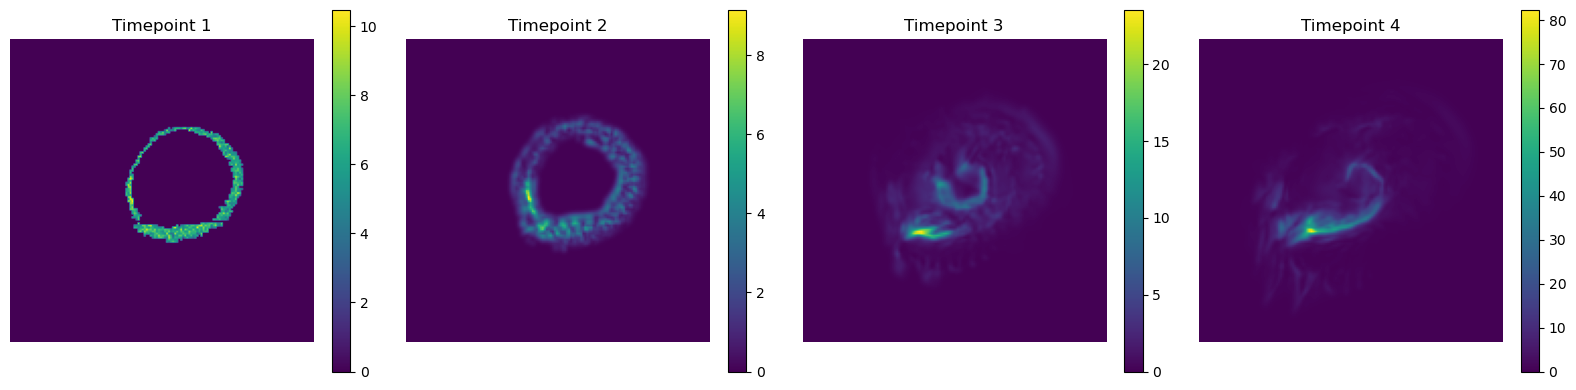

In [13]:
# plot latent representations

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for tp_col, tp_idx in enumerate(CHOSEN_TIMEPOINTS):
    ax = axes[tp_col]
    
    # Sum across all latent dimensions
    latent_sum = evolved_states[tp_idx][0].sum(dim=0).cpu().numpy()
    
    # Plot the spatial sum
    im = ax.imshow(latent_sum, cmap='viridis')
    ax.set_title(f'Timepoint {tp_idx}')
    ax.axis('off')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

